In [88]:
import torch
import numpy as np 
from datautil import *
from math import log2
train_set, test_set = read_data_as_np(None)
NUM_FEATURES = 3501
DATASET_SIZE = len(train_set)
print(f"Loaded data : Matrix size {len(train_set)} x {len(train_set[0][0])}")
print(f"Loaded data : Matrix size {len(test_set)} x {len(test_set[0][0])}")

Loaded data : Matrix size 801 x 3501
Loaded data : Matrix size 201 x 3501


In [89]:
feature_occ = [0] * NUM_FEATURES
num_p_s = [0] * NUM_FEATURES
num_n_s = [0] * NUM_FEATURES
num_p = 0
num_n = 0
for i in range(DATASET_SIZE):
    fp, tox = train_set[i]
    if tox == 1: num_p += 1 
    else: num_n += 1
    for j in range(NUM_FEATURES):
        if fp[j]: 
            feature_occ[j] += 1
            if tox == 1: num_p_s[j] += 1 
            else: num_n_s[j] += 1

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.03782949e+03 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.03782949e+03 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.03782949e+03
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.60726560e+03 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.03782949e+03 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.037829

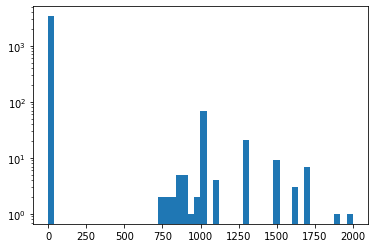

In [90]:
np.set_printoptions(threshold=sys.maxsize)

weight = [0] * NUM_FEATURES
for i in range(NUM_FEATURES):
    weight[i] = (log2((num_p_s[i] + .1) / (num_n_s[i] + .1)))
    if weight[i] > 2.5: 
        weight[i] *= 300 
    else:
        weight[i] = 1
weight = np.array(weight)
print((weight))
import matplotlib.pyplot as plt 
plt.hist(weight,bins=50, log=True)
plt.show()

In [91]:
import numpy as np
from sklearn import svm
from datautil import *

train_set, test_set = read_data_as_np(None)
weighted_train_set, weighted_test_set = read_data_as_np(weight)

print(f"Loaded data : Matrix size {len(train_set)} x {len(train_set[0][0])}")

Loaded data : Matrix size 801 x 3501


In [103]:
def X_Y_Split(data_points, use_pubchem_only = False):
    X, Y = [], []
    for idx in range(len(data_points)):
        x, y = data_points[idx]
        if use_pubchem_only:
            x = x[20:800]
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score
def evaluate_classifier(classifier, test_data, title="", use_pubchem_only=False, _print=True, full_eval = False):
    print(f"Evaluate {title}")
    testX, testY = X_Y_Split(test_data, use_pubchem_only=use_pubchem_only)
    total = testY.shape[0]
    testY = testY.ravel()
    pred = classifier.predict(testX)
    result = (pred==testY)
    correct = (np.count_nonzero(result))
    if _print:
        print(f"{correct}/{total} correct ({100*correct/total:.3f}%)")
    if full_eval:
        pred = classifier.decision_function(testX)
        test_fpr, test_tpr, te_thresholds = roc_curve(testY, pred)
        test_auc = roc_auc_score(testY, pred)
        test_aupr = average_precision_score(testY, pred)
        print(f"AUC : {test_auc}, AUPR : {test_aupr}")
    return 100*correct/total

tX, tY = X_Y_Split(train_set)
tX_2017, tY = X_Y_Split(train_set, use_pubchem_only=True)
wtX, wtY = X_Y_Split(weighted_train_set)
wtX_2017, wtY = X_Y_Split(weighted_train_set, use_pubchem_only=True)

In [104]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import *
from e3fp.fingerprint.metrics.array_metrics import soergel, tanimoto, dice, cosine, pearson

'''
poly_clf = SVC(kernel='poly', degree=5, probability=False, coef0=0)
poly_clf.fit(tX, tY)
evaluate_classifier(poly_clf, test_set, "Degree 5 polynomial")

poly_clf = SVC(kernel='poly', degree=5, probability=False, coef0=0)
poly_clf.fit(wtX, wtY)
evaluate_classifier(poly_clf, weighted_test_set, "Degree 5 polynomial-w")

poly_clf = SVC(kernel='poly', degree=5, probability=False, coef0=0)
poly_clf.fit(tX_2017, tY)
evaluate_classifier(poly_clf, test_set, "Degree 5 polynomial-pchem", use_pubchem_only=True)

poly_clf = SVC(kernel='poly', degree=5, probability=False, coef0=0)
poly_clf.fit(wtX_2017, wtY)
evaluate_classifier(poly_clf, weighted_test_set, "Degree 5 polynomial-w-pchem", use_pubchem_only=True)
'''

tanimoto_clf = SVC(kernel=tanimoto, probability=True)
tanimoto_clf.fit(tX, tY)
evaluate_classifier(tanimoto_clf, test_set, "e3fp-tanimoto", full_eval=True)
tanimoto_clf = SVC(kernel=tanimoto, probability=True)
tanimoto_clf.fit(wtX, wtY)
evaluate_classifier(tanimoto_clf, weighted_test_set, "e3fp-tanimoto-w", full_eval=True)

# use pubchem only 

tanimoto_clf = SVC(kernel=tanimoto, probability=True)
tanimoto_clf.fit(tX_2017, tY)
evaluate_classifier(tanimoto_clf, test_set, "e3fp-tanimoto-pchem", use_pubchem_only=True, full_eval=True)

tanimoto_clf = SVC(kernel=tanimoto, probability=True)
tanimoto_clf.fit(wtX_2017, wtY)
evaluate_classifier(tanimoto_clf, weighted_test_set, "e3fp-tanimoto-w-pchem", use_pubchem_only=True, full_eval=True)

/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Evaluate e3fp-tanimoto
135/201 correct (67.164%)


ValueError: continuous format is not supported

In [98]:
# 10-fold-cross validation
def train_svm_tanimoto(train_data):
    clf = SVC(kernel=tanimoto)
    train_X, train_Y = X_Y_Split(train_data, use_pubchem_only=True)
    clf.fit(train_X, train_Y)
    return clf 

def tenfold_split(data):
    cv_data = []
    data_len = len(data)
    ten_fold = []
    for i in range(10):
        ten_fold.append([])
    for i, d in enumerate(data):
        ten_fold[(i % 10)].append(d)
    for i in range(10):
        test_ith = []
        train_ith = []
        for j in range(10):
            if j == i:
                test_ith = ten_fold[j]
            else: 
                train_ith += ten_fold[j]
        cv_data.append([train_ith, test_ith])
    return cv_data

def tenfold_cross_validation(data):
    tenfold_data = tenfold_split(data)
    correct_prob = []
    for i in range(10):
        ith_clf = train_svm_tanimoto(tenfold_data[i][0])
        correct_prob.append(evaluate_classifier(ith_clf, tenfold_data[i][1], f"{i+1}th cross validation", use_pubchem_only=True, _print=False))
    print(sum(correct_prob)/10)
        
total_data = weighted_train_set + weighted_test_set
tenfold_cross_validation(total_data)

/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

Evaluate 1th cross validation
Evaluate 2th cross validation
Evaluate 3th cross validation
Evaluate 4th cross validation


/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

Evaluate 5th cross validation
Evaluate 6th cross validation
Evaluate 7th cross validation
Evaluate 8th cross validation
Evaluate 9th cross validation
Evaluate 10th cross validation
63.47227722772277


/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/gratus/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
